In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
from scipy import stats
set_matplotlib_formats("svg")
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

from ipywidgets import widgets
from IPython.display import clear_output, display

import warnings
warnings.filterwarnings('ignore')

def standard_units(any_numbers):
    "Convert a sequence of numbers to standard units."
    return (any_numbers - any_numbers.mean()) / np.std(any_numbers)

def standardize(df):
    """Return a DataFrame in which all columns of df are converted to standard units."""
    df_su = bpd.DataFrame()
    for column in df.columns:
        df_su = df_su.assign(**{column + ' (su)': standard_units(df.get(column))})
    return df_su

def correlation(df, x, y):
    '''Computes the correlation between column x and column y of df.'''
    return (standard_units(df.get(x)) * standard_units(df.get(y))).mean()

def slope(df, x, y):
    '''Returns the slope of the regression line between columns x and y in df (in original units).'''
    r = correlation(df, x, y)
    return r * np.std(df.get(y)) / np.std(df.get(x))

def intercept(df, x, y):
    '''Returns the intercept of the regression line between columns x and y in df (in original units).'''
    return df.get(y).mean() - slope(df, x, y) * df.get(x).mean()

# All of the following code is for visualization.
def plot_regression_line(df, x, y, margin=.02, alpha=1):
    '''Computes the slope and intercept of the regression line between columns x and y in df (in original units) and plots it.'''
    m = slope(df, x, y)
    b = intercept(df, x, y)
    
    df.plot(kind='scatter', x=x, y=y, s=50, figsize=(10, 5), label='original data', alpha=alpha)
    left = df.get(x).min()*(1 - margin)
    right = df.get(x).max()*(1 + margin)
    domain = np.linspace(left, right, 10)
    plt.plot(domain, m*domain + b, color='orange', label='regression line', lw=4)
    plt.suptitle(format_equation(m, b), fontsize=18)
    plt.legend();

def format_equation(m, b):
    if b > 0:
        return r'$y = %.2fx + %.2f$' % (m, b)
    elif b == 0:
        return r'$y = %.2fx' % m
    else:
        return r'$y = %.2fx %.2f$' % (m, b)

# Lecture 26 – Residuals and Inference

## DSC 10, Fall 2022

### Announcements

- The Final Project is due **tomorrow at 11:59pm**.
    - Questions about slip days? [See here](https://edstem.org/us/courses/29053/discussion/2130536).
- The Final Exam is **this Saturday 12/3 from 11:30am to 2:30pm**.
    - More details coming shortly, but start studying!
- There are several study sessions/group office hours this week, which should be helpful as you complete the final project and study for the final exam. Check the [calendar](https://dsc10.com/calendar) for all office hours.
    - Monday 11/28 from 12-2pm in PCNYH 122.
    - Tuesday 11/29 from 7-9pm in SDSC Auditorium (with no heat 🥶; dress warmly 🧣).
    - Wednesday 11/30 from 3-7pm in SDSC Auditorium (with no heat 🥶; dress warmly 🧣).
    - Friday 12/2 from 5-9pm in WLH 2205.
- Lecture section C00 is not meeting today – Suraj is in India 🇮🇳. 
    - C00 will be meeting again this Wednesday and Friday.

### Agenda

- Residuals.
- Inference for regression.

## Residuals

### Quality of fit

- The regression line describes the "best linear fit" for a given dataset.
- The formulas for the slope and intercept work no matter what the shape of the data is.
- However, the line is only meaningful if the relationship between $x$ and $y$ is roughly linear.

### Example: Non-linear data

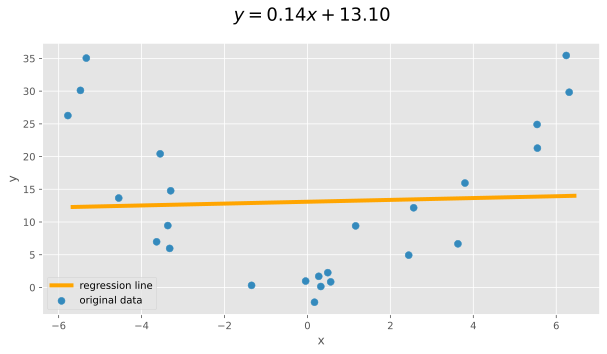

In [2]:
np.random.seed(23)
x2 = bpd.DataFrame().assign(
    x=np.arange(-6, 6.1, 0.5) + np.random.normal(size=25), 
    y=np.arange(-6, 6.1, 0.5)**2 + np.random.normal(size=25)
)
plot_regression_line(x2, 'x', 'y')

This line doesn't fit the data at all, despite being the "best" line for the data!

### Residuals

- Any set of predictions has _errors_.

$$\text{error} = \text{actual } y - \text{predicted } y$$


- When using the regression line to make predictions, the errors are called **residuals**.
     
$$\text{residual} = \text{actual } y - \text{predicted } y \text{ by regression line}$$

- There is one residual corresponding to each data point $(x, y)$ in the dataset.

### Calculating residuals

In [3]:
def predicted(df, x, y):
    m = slope(df, x, y)
    b = intercept(df, x, y)
    return m * df.get(x) + b

def residual(df, x, y):
    return df.get(y) - predicted(df, x, y)

### Example: Predicting a son's height from his mother's height  👵👨 📏

Is the association between `'mom'` and `'son'` linear?

- If there is a linear association, is it strong?
    - We can answer this using the correlation coefficient.
    - Close to 0 = weak, close to -1/+1 = strong.

- Is "linear" the best description of the association between `'mom'` and `'son'`?
    - **We'll use residuals to answer this question.**

In [6]:
galton = bpd.read_csv('data/galton.csv')

male_children = galton[galton.get('gender') == 'male']
mom_son = bpd.DataFrame().assign(mom = male_children.get('mother'), 
                                 son = male_children.get('childHeight'))

mom_son_predictions = mom_son.assign(
    predicted=predicted(mom_son, 'mom', 'son'),
    residuals=residual(mom_son, 'mom', 'son'),
)

Correlation: 0.32300498368490554


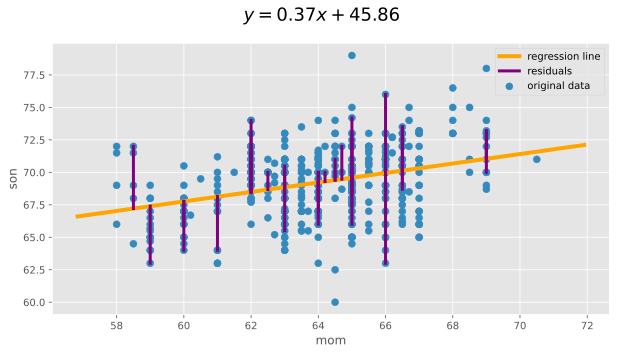

In [14]:
plot_regression_line(mom_son_predictions, 'mom', 'son')

idx = np.random.randint(0, mom_son_predictions.shape[0], size=50)
for i, k in enumerate(idx):
    x = mom_son_predictions.get('mom').iloc[k]
    y = mom_son_predictions.get('son').iloc[k]
    p = mom_son_predictions.get('predicted').iloc[k]
    plt.plot([x,x], [y,p], linewidth=3, color='purple', label='residuals' if i==0 else None)
plt.legend();
print('Correlation:', correlation(mom_son, 'mom', 'son'))

### Residual plots

- The residual plot of a regression line is the scatter plot with the $x$ variable on the $x$-axis and residuals on the $y$-axis.

    $$\text{residual} = \text{actual } y - \text{predicted } y \text{ by regression line}$$



- Residual plots describe how the error in the regression line's predictions varies.

- **Key idea: If a linear fit is good, the residual plot should look like a **patternless "cloud" ☁️.**

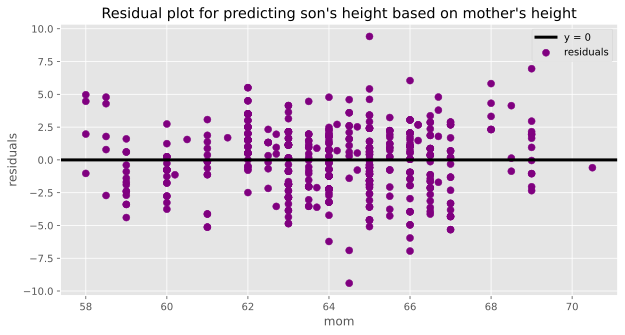

In [8]:
mom_son_predictions.plot(kind='scatter', x='mom', y='residuals', s=50, c='purple', figsize=(10, 5), label='residuals')
plt.axhline(0, linewidth=3, color='k', label='y = 0')
plt.title('Residual plot for predicting son\'s height based on mother\'s height')
plt.legend();

### The residual plot for a non-linear association 🚗
- Consider the hybrid cars dataset from earlier. 
- Let's look at a regression line that uses `'mpg'` to predict `'msrp'`.

In [15]:
hybrid = bpd.read_csv('data/hybrid.csv')
mpg_msrp = hybrid.assign(
    predicted=predicted(hybrid, 'mpg', 'msrp'),
    residuals=residual(hybrid, 'mpg', 'msrp')
)
mpg_msrp

,vehicle,year,msrp,acceleration,mpg,class,predicted,residuals
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact,32609.64,-8099.90
1,Tino,2000,35354.97,8.20,54.10,Compact,19278.39,16076.58
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact,28487.75,-1655.50
...,...,...,...,...,...,...,...,...
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize,30803.06,2146.94
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize,30803.06,7896.94
152,Chevrolet Volt,2013,39145.00,11.11,37.00,Compact,37032.62,2112.38


Correlation: -0.5318263633683789


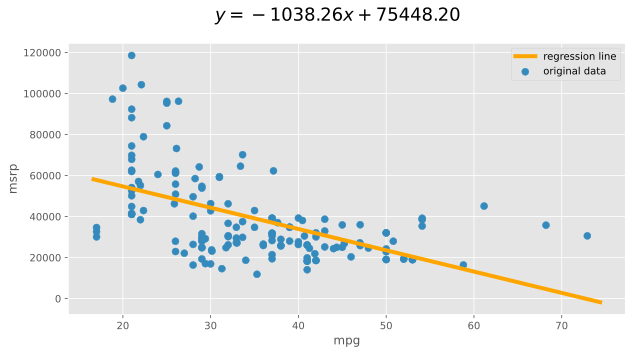

In [16]:
# Plot of the original data and regression line.
plot_regression_line(hybrid, 'mpg', 'msrp');
print('Correlation:', correlation(hybrid, 'mpg', 'msrp'))

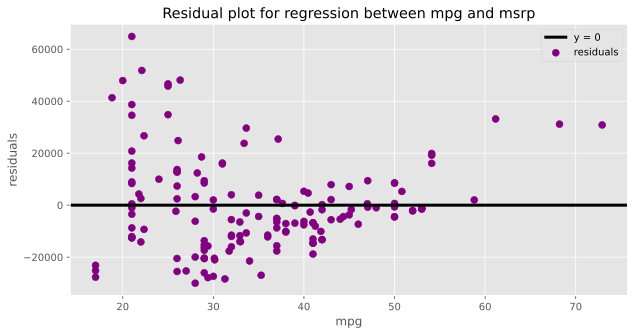

In [17]:
# Residual plot.
mpg_msrp.plot(kind='scatter', x='mpg', y='residuals', figsize=(10, 5), s=50, color='purple', label='residuals')
plt.axhline(0, linewidth=3, color='k', label='y = 0')
plt.title('Residual plot for regression between mpg and msrp')
plt.legend();

Note that as `'mpg'` increases, the residuals go from being mostly large, to being mostly small, to being mostly large again. That's a pattern!

### Issue: Patterns in the residual plot

- Patterns in the residual plot imply that the relationship between $x$ and $y$ may not be linear.
    - While this can be spotted in the original scatter plot, it may be easier to identify in the residual plot.

- In such cases, a curve may be a better choice than a line for prediction.
    - In future courses, you'll learn how to extend linear regression to work for polynomials and other types of mathematical functions.

### Another example: `'mpg'` and `'acceleration'` ⛽

- Let's fit a regression line that predicts `'mpg'` given `'acceleration'`.
- Let's then look at the resulting residual plot.

In [18]:
accel_mpg = hybrid.assign(
    predicted=predicted(hybrid, 'acceleration', 'mpg'),
    residuals=residual(hybrid, 'acceleration', 'mpg')
)
accel_mpg

,vehicle,year,msrp,acceleration,mpg,class,predicted,residuals
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact,43.29,-2.03
1,Tino,2000,35354.97,8.20,54.10,Compact,41.90,12.20
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact,42.33,2.90
...,...,...,...,...,...,...,...,...
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize,35.17,7.83
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize,35.17,7.83
152,Chevrolet Volt,2013,39145.00,11.11,37.00,Compact,36.40,0.60


Correlation: -0.5060703843771185


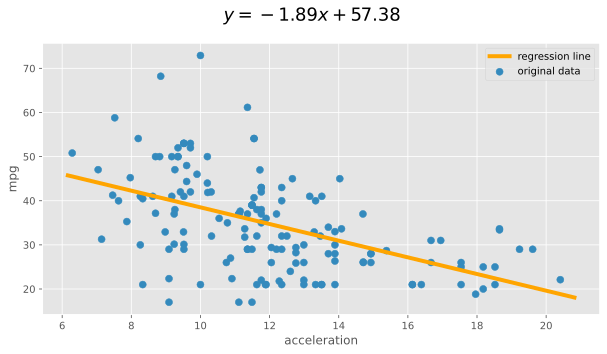

In [19]:
# Plot of the original data and regression line.
plot_regression_line(accel_mpg, 'acceleration', 'mpg')
print('Correlation:', correlation(accel_mpg, 'acceleration', 'mpg'))

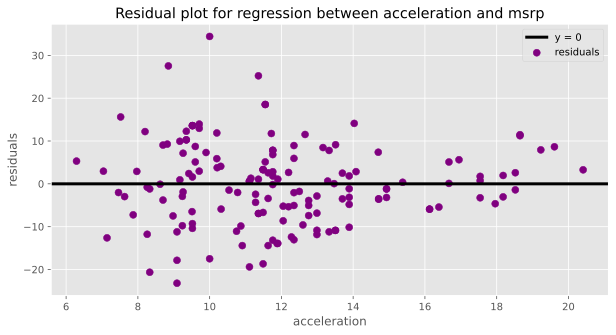

In [20]:
# Residual plot.
accel_mpg.plot(kind='scatter', x='acceleration', y='residuals', figsize=(10, 5), s=50, color='purple', label='residuals')
plt.axhline(0, linewidth=3, color='k', label='y = 0')
plt.title('Residual plot for regression between acceleration and msrp')
plt.legend();

Note that the residuals tend to vary more for smaller accelerations than they do for larger accelerations – that is, the vertical spread of the plot is **not** similar at all points on the $x$-axis.

### Issue: Uneven vertical spread

- If the vertical spread in a residual plot is uneven, it implies that the regression line's predictions aren't equally reliable for all inputs.
    - This doesn't necessarily mean that fitting a non-linear curve would be better; it just impacts how we interpret the regression line's predictions.
    - For instance, in the previous plot, we see that the regression line's predictions for cars with larger accelerations are more reliable than those for cars with lower accelerations.

- The formal term for "uneven spread" is **heteroscedasticity**.

### Example: Anscombe's quartet

<center><img src='data/anscombe.png' width=800></center>

- All 4 datasets have the same mean of $x$, mean of $y$, SD of $x$, SD of $y$, and correlation.
    - Therefore, they have the same regression line because the slope and intercept of the regression line are determined by these 5 quantities.
- But they all look very different!
- Not all of them are linearly associated. 

### Example: The Datasaurus Dozen 🦖

> Never trust summary statistics alone; always visualize your data!

<center><img src='data/datasaurus.png' width=800><br>(<a href=https://www.autodesk.com/research/publications/same-stats-different-graphs>source</a>)</center>

## Inference for regression

### Another perspective on regression

- What we're really doing:
    - Collecting a sample of data from a population.
    - Fitting a regression line to that sample.
    - Using that regression line to make predictions for inputs that are not in our sample.

- What if we used a different sample? 🤔

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

What strategy will help us assess how different our regression line's predictions would have been if we'd used a different sample?

- A. Hypothesis testing
- B. Permutation testing
- C. Bootstrapping
- D. Central Limit Theorem

### Prediction intervals

We want to come up with a range of reasonable values for a prediction for a single input $x$. To do so, we'll:

1. Bootstrap the sample.
2. Compute the slope and intercept of the regression line for that sample.
3. Repeat steps 1 and 2 many times to compute many slopes and many intercepts.
4. For a given $x$, use the bootstrapped slopes and intercepts to create bootstrapped predictions, and take the middle 95% of them.

The resulting interval will be called a **prediction interval**.

### Bootstrapping the scatter plot of mother/son heights

Note that each time we run this cell, the resulting line is slighty different!

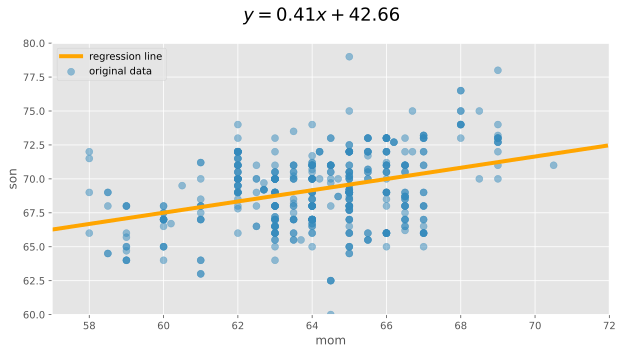

In [21]:
# Step 1: Resample the dataset.
resampled = mom_son.sample(mom_son.shape[0], replace=True)

# Step 2: Compute the slope and intercept of the regression line for that resample.
plot_regression_line(resampled, 'mom', 'son', alpha=0.5)

plt.ylim([60, 80])
plt.xlim([57, 72]);

### Bootstrapping predictions: mother/son heights

In [22]:
m_orig = slope(mom_son, 'mom', 'son')
b_orig = intercept(mom_son, 'mom', 'son')

In [23]:
boot_slopes = np.array([])
boot_intercepts = np.array([])

for i in np.arange(5000):
    # Step 1: Resample the dataset.
    resample = mom_son.sample(mom_son.shape[0], replace=True)
    
    # Step 2: Compute the slope and intercept of the regression line for that resample.
    m = slope(resample, 'mom', 'son')
    b = intercept(resample, 'mom', 'son')
    boot_slopes = np.append(boot_slopes, m)
    boot_intercepts = np.append(boot_intercepts, b)

### If a mother is 68 inches tall, how tall do we predict her son to be?

In [24]:
mom = 68

Using the original dataset, and hence the original slope and intercept, we get a single prediction for the input of 68.

In [25]:
pred_orig = m_orig * mom + b_orig
pred_orig

70.68219686848828

Using the bootstrapped slopes and intercepts, we get an **interval** of predictions for the input of 68.

In [26]:
boot_preds = boot_slopes * mom + boot_intercepts
boot_preds

array([70.79, 70.74, 70.65, ..., 70.77, 70.88, 70.77])

In [27]:
l = np.percentile(boot_preds, 2.5)
r = np.percentile(boot_preds, 97.5)
[l, r]

[70.20687130229958, 71.15105647243745]

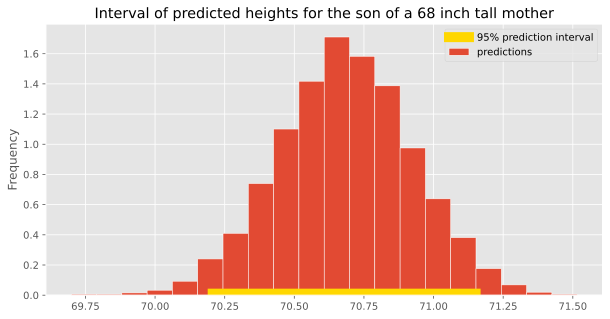

In [28]:
bpd.DataFrame().assign(
    predictions=boot_preds
).plot(kind='hist', density=True, bins=20, figsize=(10, 5), ec='w', title='Interval of predicted heights for the son of a 68 inch tall mother')
plt.plot([l,r],[0.01,0.01], c='gold', linewidth=10, zorder=1, label='95% prediction interval')
plt.legend();

### How different could our prediction have been, for all inputs?

Here, we'll plot several of our bootstrapped lines. What do you notice?

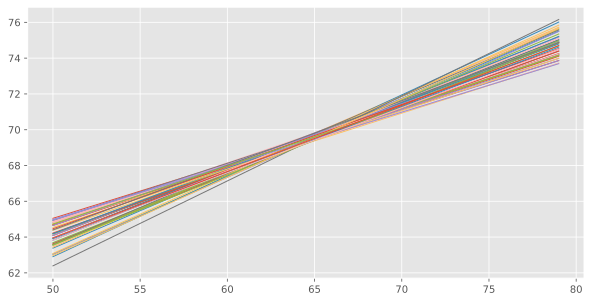

In [29]:
# Don't worry about the code for this.
plt.figure(figsize=(10, 5))
x = np.arange(50, 80)
ys = []
for i, (m, b) in enumerate(zip(boot_slopes[:50], boot_intercepts)):
    ys.append(m * x + b)
    fig = plt.plot(x, m * x + b, linewidth=1)        

**Observations**:
- All bootstrapped lines pass through $$(\text{mean mother's height in resample}, \text{mean son's height in resample})$$
- Predictions seem to vary more for very tall and very short mothers than they do for mothers with an average height.

### Prediction interval width vs. mother's height

In [30]:
# Don't worry about the code for this.

def pred_interval(mom):
    plt.figure(figsize=(10, 5))
    x = np.arange(50, 80)
    ys = []
    for i, (m, b) in enumerate(zip(boot_slopes[:50], boot_intercepts)):
        ys.append(m * x + b)
        plt.plot(x, m * x + b, linewidth=1, alpha=0.1)  
        
    boot_preds = boot_slopes * mom + boot_intercepts
    l = np.percentile(boot_preds, 2.5)
    r = np.percentile(boot_preds, 97.5)
    plt.plot([mom, mom], [l, r], linewidth=5, color='#eb7e35', label='95% prediction interval')
    plt.xlim(50, 80)
    plt.ylim(62, 77)
    plt.title(f'95% prediction interval for the height of a son whose mother is {mom} inches tall: {[np.round(l, 3), np.round(r, 3)]}')
    plt.legend()
    plt.show()

def slider_widget():
    mom_slider = widgets.IntSlider(value=64, min=50, max=78, step=1, description="mom's height")
    ui = widgets.HBox([mom_slider])
    out = widgets.interactive_output(pred_interval, {'mom': mom_slider})
    display(ui, out)

slider_widget()

Output()

Note that **the closer a mother's height is to the mean mother's height, the narrower the prediction interval for her son's height is!**

## Summary, next time

### Summary

- Residuals are the errors in the predictions made by the regression line.
$$\text{residual} = \text{actual } y - \text{predicted } y \text{ by regression line}$$
- Residual plots help us determine whether a line is a good fit to our data.
    - No pattern in residual plot = good linear fit.
    - Patterns in residual plot = poor linear fit.
    - The correlation coefficient, $r$, doesn't tell the full story! 🦖
- To see how our predictions might have been different if we'd had a different sample, bootstrap!
    - Resample the data points and make a prediction using the regression line for each resample.
    - Many resamples lead to many predictions. Take the middle 95% of them to get a **95% prediction interval**.

### Next time

- We're done with introducing new material!
- We'll review in class on Wednesday and Friday.
- The final exam is this Saturday 12/3 from 11:30am to 2:30pm.